In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

In [2]:
train_df = pd.read_csv("data/twitter_data_train_multiclass.csv")
test_df = pd.read_csv("data/twitter_data_test_multiclass.csv")

print(train_df.shape)
print(test_df.shape)

(9446, 237)
(1667, 237)


### LSTM and RNN On Account's Description Text

In [3]:
train = train_df[['description_processed','tweets_list_processed', 'account_type_multi']]
test = test_df[['description_processed','tweets_list_processed','account_type_multi']]

train['description_processed'] = train['description_processed'].apply(str)
test['description_processed'] = test['description_processed'].apply(str)

C:\Users\radellng\AppData\Local\Temp\ipykernel_1876\1025729854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['description_processed'] = train['description_processed'].apply(str)
C:\Users\radellng\AppData\Local\Temp\ipykernel_1876\1025729854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['description_processed'] = test['description_processed'].apply(str)


In [4]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['description_processed'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_test.fit_on_texts(test['description_processed'].values)
word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(word_index_test))

Found 16349 unique tokens.
Found 4366 unique tokens.


In [5]:
X = tokenizer.texts_to_sequences(train['description_processed'].values)
X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

x = tokenizer_test.texts_to_sequences(test['description_processed'].values)
X_test = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (9446, 250)
Shape of data tensor: (1667, 250)


In [6]:
y_train = to_categorical(train['account_type_multi'], num_classes=4)
y_test = to_categorical(test['account_type_multi'], num_classes=4)

print(y_train.shape)
print(y_test.shape)

(9446, 4)
(1667, 4)


In [7]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 6,449,668
Trainable params: 6,449,668
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
133/133 [==============================] - 59s 425ms/step - loss: 1.1069 - accuracy: 0.5024 - val_loss: 0.9401 - val_accuracy: 0.5778
Epoch 2/10
133/133 [==============================] - 59s 444ms/step - loss: 0.9097 - accuracy: 0.6042 - val_loss: 0.8976 - val_accuracy: 0.6074
Epoch 3/10
133/133 [==============================] - 58s 434ms/step - loss: 0.8407 - accuracy: 0.6589 - val_loss: 0.8690 - val_accuracy: 0.6423
Epoch 4/10
133/133 [==============================] - 56s 421ms/step - loss: 0.7663 - accuracy: 0.7117 - val_loss: 0.8204 - val_accuracy: 0.6857
Epoch 5/10
133/133 [==============================] - 58s 439ms/step - loss: 0.6952 - accuracy: 0.7510 - val_loss: 0.8145 - val_accuracy: 0.6825
Epoch 6/10
133/133 [==============================] - 57s 426ms/step - loss: 0.6409 - accuracy: 0.7716 - val_loss: 0.8005 - val_accuracy: 0.6910
Epoch 7/10
133/133 [==============================] - 57s 429ms/step - loss: 0.5924 - accuracy: 0.7907 - val_loss: 0.8228 - val_ac

In [9]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(classification_report(test['account_type_multi'], pred, digits=5))

53/53 [==============================] - 2s 33ms/step - loss: 1.5551 - accuracy: 0.5537
Test set
  Loss: 1.555
  Accuracy: 0.554
53/53 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

           0    0.48301   0.48184   0.48242       413
           1    0.40828   0.30000   0.34586       460
           2    0.71951   0.64130   0.67816       276
           3    0.60954   0.78958   0.68797       518

    accuracy                        0.55369      1667
   macro avg    0.55509   0.55318   0.54861      1667
weighted avg    0.54086   0.55369   0.54102      1667



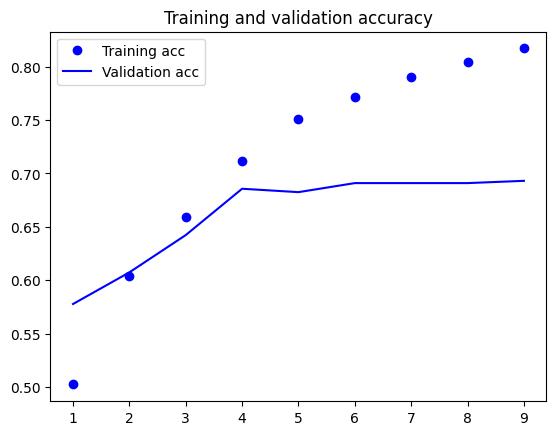

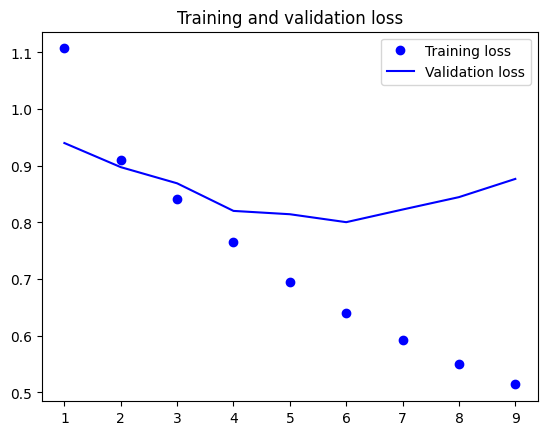

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### LSTM and RNN On Account's Tweets Text

In [11]:
train['tweets_list_processed'] = train['tweets_list_processed'].apply(str)
test['tweets_list_processed'] = test['tweets_list_processed'].apply(str)

tweet_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tweet_tokenizer.fit_on_texts(train['tweets_list_processed'].values)
tweet_word_index = tweet_tokenizer.word_index
print('Found %s unique tokens.' % len(tweet_word_index))

tweet_tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tweet_tokenizer_test.fit_on_texts(test['tweets_list_processed'].values)
tweet_word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(tweet_word_index_test))


C:\Users\radellng\AppData\Local\Temp\ipykernel_1876\866718681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tweets_list_processed'] = train['tweets_list_processed'].apply(str)
C:\Users\radellng\AppData\Local\Temp\ipykernel_1876\866718681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tweets_list_processed'] = test['tweets_list_processed'].apply(str)


Found 1290669 unique tokens.
Found 4366 unique tokens.


In [12]:
X_tweets = tweet_tokenizer.texts_to_sequences(train['tweets_list_processed'].values)
X_train_tweets = pad_sequences(X_tweets, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_tweets.shape)

x_tweets = tweet_tokenizer_test.texts_to_sequences(test['tweets_list_processed'].values)
X_tweets_test = pad_sequences(x_tweets, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_tweets_test.shape)

Shape of data tensor: (9446, 250)
Shape of data tensor: (1667, 250)


In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_tweets.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
epochs = 10
batch_size = 64

history = model.fit(X_train_tweets, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,449,668
Trainable params: 6,449,668
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
133/133 [==============================] - 64s 463ms/step - loss: 1.1088 - accuracy: 0.4432 - 

In [14]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(classification_report(test['account_type_multi'], pred, digits=5))

53/53 [==============================] - 2s 33ms/step - loss: 3.3135 - accuracy: 0.1902
Test set
  Loss: 3.313
  Accuracy: 0.190
53/53 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0    0.50000   0.00242   0.00482       413
           1    0.42188   0.11739   0.18367       460
           2    0.16992   0.94565   0.28808       276
           3    1.00000   0.00193   0.00385       518

    accuracy                        0.19016      1667
   macro avg    0.52295   0.26685   0.12011      1667
weighted avg    0.57916   0.19016   0.10077      1667



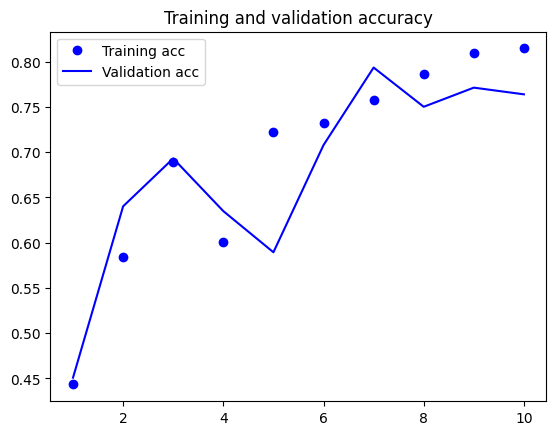

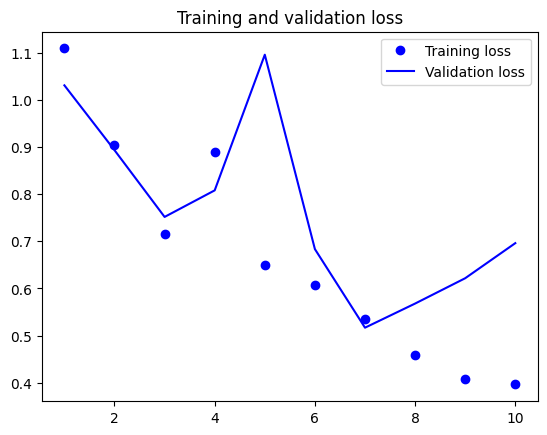

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()